# Music Generation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from utils import *
from hmm import HMM

In [3]:
data = load_jsb_chorales()

Text(0, 0.5, 'Count')

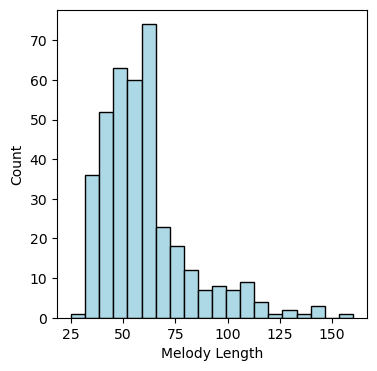

In [4]:
lengths = [len(song) for song in data]

fig, ax = plt.subplots(figsize=(4,4))
ax.hist(lengths, bins=20, color='lightblue', edgecolor='black')
ax.set_xlabel('Melody Length')
ax.set_ylabel('Count')

## Our

In [5]:
x = np.array(data[0])

In [6]:
model = HMM(n_hidden=2, n_obs=np.max(x)+1)
model.fit(x, n_iter=100)

state_sequence = model.predict(x)

In [7]:
x_sample, state_sequence = model.sample(50)

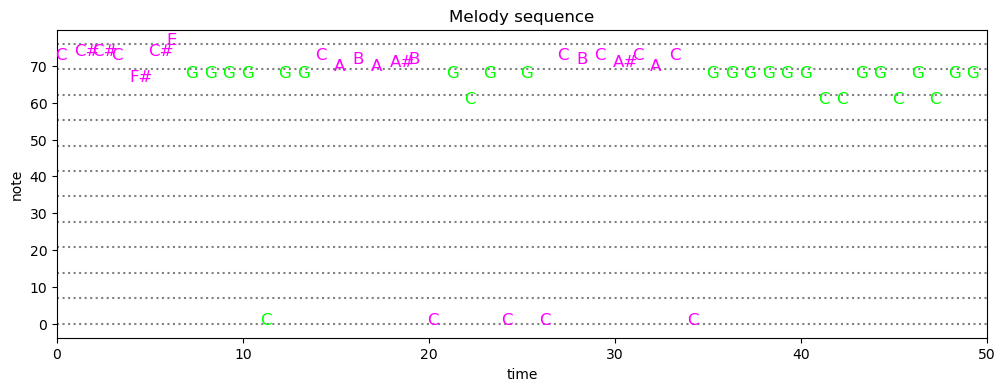

In [8]:
plot_sequence(x_sample, state_sequence)

## Reference

In [9]:
seq_train = data[:300]
lengths = np.array([len(song) for song in seq_train])

x_train = np.concatenate([melody[:length] for length, melody in zip(lengths, seq_train)]).reshape(-1, 1)

In [10]:
from hmmlearn.hmm import CategoricalHMM

In [11]:
model = CategoricalHMM(n_components=2, n_iter=100)
model.fit(x_train, lengths)

CategoricalHMM(n_components=2, n_features=94, n_iter=100,
               random_state=RandomState(MT19937) at 0x7614A0758740)

In [12]:
x_sample, state_sequence = model.sample(n_samples=50)

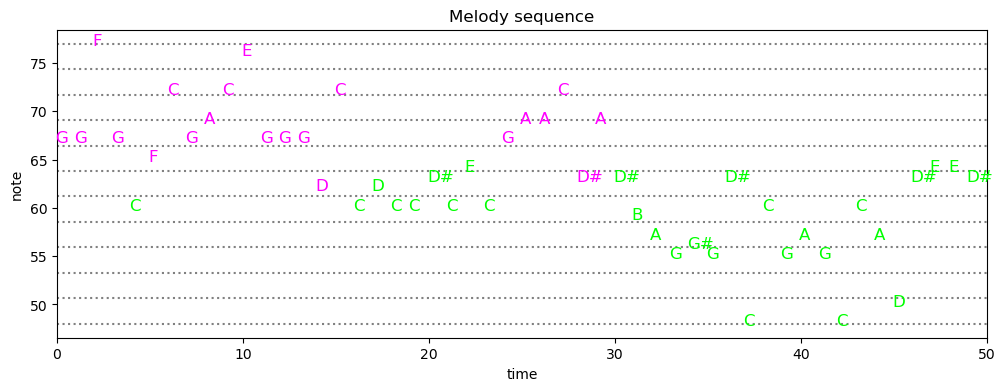

In [13]:
plot_sequence(x_sample[:,0], state_sequence)

In [14]:
write_midi_file(x_sample[:,0], "out/test.mid")

In [15]:
!timidity "out/test.mid"

Playing out/test.mid
MIDI file: out/test.mid
Format: 1  Tracks: 2  Divisions: 960
Playing time: ~16 seconds
Notes cut: 0
Notes lost totally: 0
